In [29]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
# Load the datasets
economy_df = pd.read_csv('https://opendata.com.pk/dataset/4acccdea-baea-4bc7-8499-94835f352059/resource/5eed074c-c7ed-427a-816c-8482edb070a1/download/economy-and-growth_pak.csv')
climate_df = pd.read_csv('https://opendata.com.pk/dataset/ececec4f-1835-4278-ae0c-5bd7c4ded652/resource/492b13f4-5b47-4437-a680-4e1b965c1ea2/download/climate-change-indicators-for-pakistan-1.csv')

# Clean the data by removing the first row (header information) and resetting the index
economy_df = economy_df[1:].reset_index(drop=True)
climate_df = climate_df[1:].reset_index(drop=True)

# Convert the Year and Value columns to numeric
economy_df['Year'] = pd.to_numeric(economy_df['Year'])
economy_df['Value'] = pd.to_numeric(economy_df['Value'], errors='coerce')

climate_df['Year'] = pd.to_numeric(climate_df['Year'])
climate_df['Value'] = pd.to_numeric(climate_df['Value'], errors='coerce')

# Pivot the data to have indicators as columns
economy_pivot = economy_df.pivot_table(index='Year', columns='Indicator Name', values='Value')
climate_pivot = climate_df.pivot_table(index='Year', columns='Indicator Name', values='Value')

# Merge the two datasets on the Year column
merged_df = pd.merge(economy_pivot, climate_pivot, on='Year', how='inner')

# Define the selected indicators
selected_indicators = [
    'Agricultural land (sq. km)',
    'Urban population',
    'CO2 emissions (kt)',
    'Electric power consumption (kWh per capita)',
    'Forest area (sq. km)',
    'Cereal yield (kg per hectare)',
    'Inflation, consumer prices (annual %)'

]

# Filter the merged DataFrame to include only the selected indicators
merged_df = merged_df[selected_indicators]
# Filter the data to include only the years between 1970 and 2014
merged_df = merged_df[(merged_df.index >= 1970) & (merged_df.index <= 2014)]
scaler = StandardScaler()
scaled_df = pd.DataFrame(scaler.fit_transform(merged_df.dropna()), columns=merged_df.columns, index=merged_df.dropna().index)





# Calculate the correlation matrix
correlation_matrix = scaled_df.corr()

# Display the correlation matrix
print("\nCorrelation Matrix:")
print(correlation_matrix)



Correlation Matrix:
Indicator Name                               Agricultural land (sq. km)  \
Indicator Name                                                            
Agricultural land (sq. km)                                     1.000000   
Urban population                                               0.056731   
CO2 emissions (kt)                                            -0.028119   
Electric power consumption (kWh per capita)                    0.020556   
Forest area (sq. km)                                          -0.069579   
Cereal yield (kg per hectare)                                  0.056109   
Inflation, consumer prices (annual %)                         -0.770753   

Indicator Name                               Urban population  \
Indicator Name                                                  
Agricultural land (sq. km)                           0.056731   
Urban population                                     1.000000   
CO2 emissions (kt)                         


## Analysis of Correlation Between Economic and Climate Change Indicators

This analysis aims to find the correlation between various economic and climate change indicators in Pakistan. The goal is to identify which environmental factors contribute the most to the economy and where there is a need for improvement.

### Loading the Data
The datasets are loaded and cleaned by removing the initial row containing header information and converting necessary columns to numeric types.

### Pivoting the Data
The data is pivoted to have indicators as columns, allowing for easier analysis of correlations between them.

### Calculating the Correlation Matrix
A correlation matrix is calculated to show the relationship between each pair of indicators. Positive values indicate a direct relationship, while negative values indicate an inverse relationship.

### Key Findings
1. Identify the top correlated indicators for both economic and climate change indicators.
2. Determine which climate change indicators have the most significant impact on economic indicators.
3. Highlight areas where there is a need for improvement based on weak or negative correlations.

The following sections provide the detailed analysis.


In [30]:

# Identify top correlated indicators
top_correlations = correlation_matrix.unstack().sort_values(ascending=False)
top_correlations.head(20)


Indicator Name                               Indicator Name                             
Agricultural land (sq. km)                   Agricultural land (sq. km)                     1.000000
Urban population                             Urban population                               1.000000
CO2 emissions (kt)                           CO2 emissions (kt)                             1.000000
Forest area (sq. km)                         Forest area (sq. km)                           1.000000
Electric power consumption (kWh per capita)  Electric power consumption (kWh per capita)    1.000000
Cereal yield (kg per hectare)                Cereal yield (kg per hectare)                  1.000000
Inflation, consumer prices (annual %)        Inflation, consumer prices (annual %)          1.000000
Urban population                             CO2 emissions (kt)                             0.982640
CO2 emissions (kt)                           Urban population                               0.982640
Ur

In [31]:

# Identify weak or negative correlations
weak_negative_correlations = top_correlations[(top_correlations < 0.3) & (top_correlations > -0.3)]
weak_negative_correlations.head(20)


Indicator Name                               Indicator Name                             
Inflation, consumer prices (annual %)        CO2 emissions (kt)                             0.153470
CO2 emissions (kt)                           Inflation, consumer prices (annual %)          0.153470
Electric power consumption (kWh per capita)  Inflation, consumer prices (annual %)          0.099638
Inflation, consumer prices (annual %)        Electric power consumption (kWh per capita)    0.099638
                                             Urban population                               0.066694
Urban population                             Inflation, consumer prices (annual %)          0.066694
Agricultural land (sq. km)                   Urban population                               0.056731
Urban population                             Agricultural land (sq. km)                     0.056731
Agricultural land (sq. km)                   Cereal yield (kg per hectare)                  0.056109
Ce

In [32]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# Display results


In [33]:


# Define a function to perform Granger causality tests for all pairs of indicators
def granger_causality_tests(data, max_lag=5):
    results = {}
    for col1 in data.columns:
        for col2 in data.columns:
            if col1 != col2:
                series = data[[col1, col2]].dropna()
                if len(series) > max_lag + 1:  # Ensure there are enough observations
                    try:
                        test_result = grangercausalitytests(series, max_lag, verbose=False)
                        p_values = [round(test_result[i+1][0]['ssr_ftest'][1], 4) for i in range(max_lag)]
                        min_p_value = min(p_values)
                        if min_p_value < 0.05:
                            results[(col1, col2)] = min_p_value
                    except ValueError:
                        continue
    return results

# Determine the maximum lag based on the length of the dataset
max_lag = min(5, len(merged_df) // 2 - 1)

# Perform Granger causality tests
causality_results = granger_causality_tests(merged_df.dropna(), max_lag)

# Display results
for key, value in causality_results.items():
    print(f"{key[0]} causes {key[1]}: p-value = {value}")

Agricultural land (sq. km) causes Forest area (sq. km): p-value = 0.0421
CO2 emissions (kt) causes Electric power consumption (kWh per capita): p-value = 0.0008
CO2 emissions (kt) causes Forest area (sq. km): p-value = 0.0368
Electric power consumption (kWh per capita) causes Urban population: p-value = 0.0136
Electric power consumption (kWh per capita) causes CO2 emissions (kt): p-value = 0.0261
Electric power consumption (kWh per capita) causes Forest area (sq. km): p-value = 0.0284
Forest area (sq. km) causes Urban population: p-value = 0.0
Cereal yield (kg per hectare) causes Urban population: p-value = 0.0
Cereal yield (kg per hectare) causes CO2 emissions (kt): p-value = 0.0004
Cereal yield (kg per hectare) causes Forest area (sq. km): p-value = 0.0
Inflation, consumer prices (annual %) causes Agricultural land (sq. km): p-value = 0.0193
Inflation, consumer prices (annual %) causes CO2 emissions (kt): p-value = 0.0054


In [34]:

# Pairplot for highly correlated indicators
high_corr_pairs = top_correlations[top_correlations > 0.8]
high_corr_indicators = list(set([x[0] for x in high_corr_pairs.index]))



In [35]:
high_corr_indicators

['Electric power consumption (kWh per capita)',
 'Cereal yield (kg per hectare)',
 'CO2 emissions (kt)',
 'Forest area (sq. km)',
 'Inflation, consumer prices (annual %)',
 'Urban population',
 'Agricultural land (sq. km)']

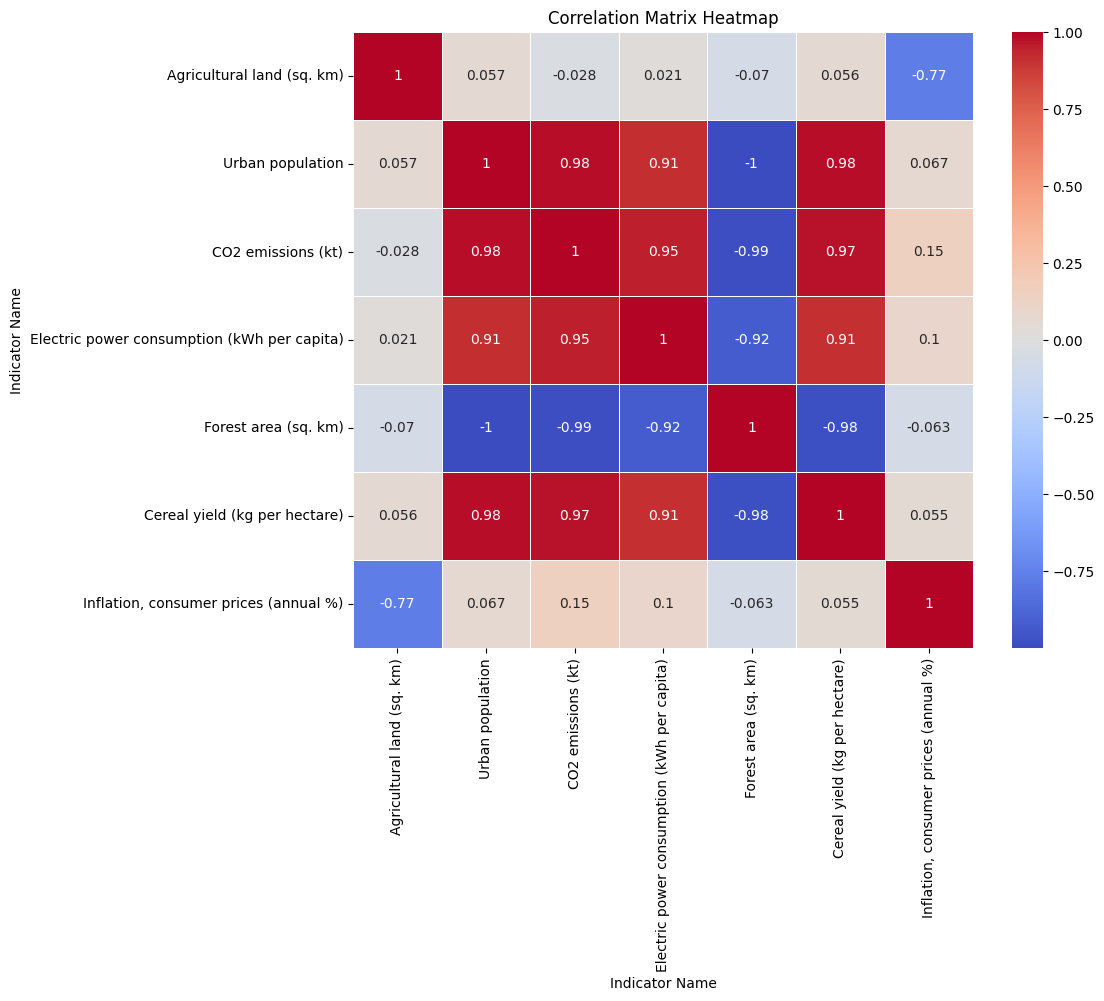

In [38]:
# Heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()



Granger Causality Test Results:
Agricultural land (sq. km) causes Forest area (sq. km): p-value = 0.0421
CO2 emissions (kt) causes Electric power consumption (kWh per capita): p-value = 0.0008
CO2 emissions (kt) causes Forest area (sq. km): p-value = 0.0368
Electric power consumption (kWh per capita) causes Urban population: p-value = 0.0136
Electric power consumption (kWh per capita) causes CO2 emissions (kt): p-value = 0.0261
Electric power consumption (kWh per capita) causes Forest area (sq. km): p-value = 0.0284
Forest area (sq. km) causes Urban population: p-value = 0.0
Cereal yield (kg per hectare) causes Urban population: p-value = 0.0
Cereal yield (kg per hectare) causes CO2 emissions (kt): p-value = 0.0004
Cereal yield (kg per hectare) causes Forest area (sq. km): p-value = 0.0


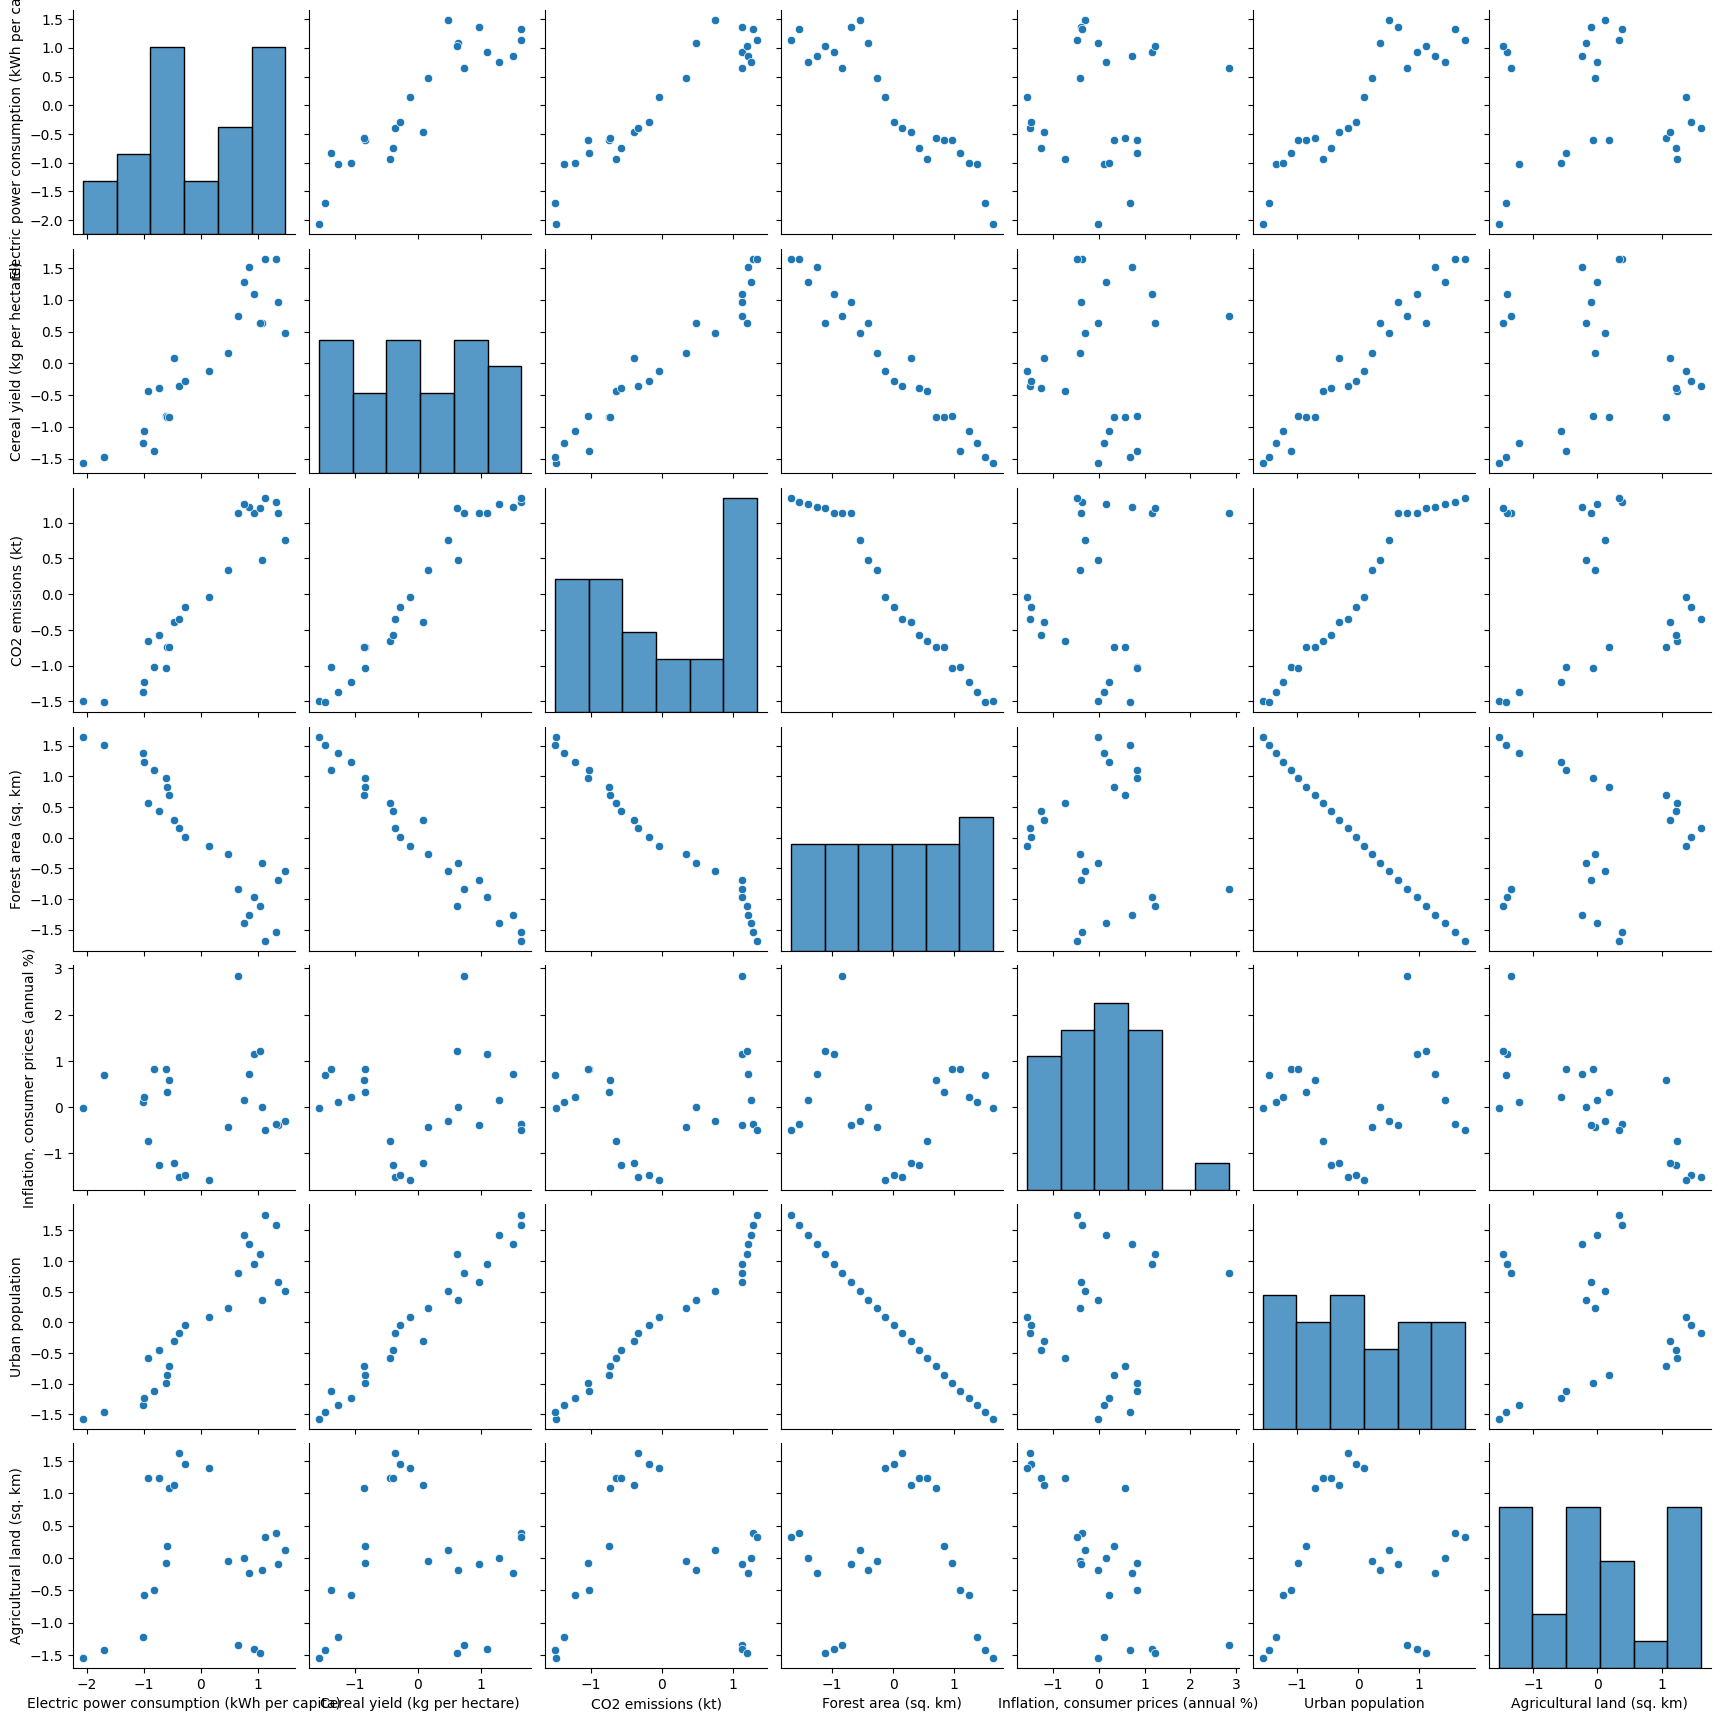

In [37]:
sns.pairplot(scaled_df[high_corr_indicators])


## Conclusions

Based on the correlation analysis, the key environmental factors contributing the most to economic indicators and areas needing improvement are identified. Detailed insights and recommendations are provided to guide future actions and policies.

Key Visualizations Correlation Matrix Heatmap: This heatmap shows the correlation between all pairs of indicators, with darker colors indicating stronger correlations. It provides a visual overview of the relationships between economic and climate change indicators. Pairplot for Highly Correlated Indicators: This pairplot visualizes the relationships between the most highly correlated indicators, providing a deeper insight into how specific indicators interact with each other. Recommendations Focus on Strong Correlations: Indicators with strong positive correlations should be prioritized for policy and action, as improvements in these areas are likely to have the most significant economic impact. Address Weak and Negative Correlations: Areas with weak or negative correlations should be investigated further to understand the underlying causes and develop targeted interventions to improve these relationships. By understanding these correlations, policymakers and stakeholders can make more informed decisions to foster sustainable economic growth while addressing climate change challenges.
